In [1]:
#Importing packages and modules

%matplotlib inline
import numpy as np
import pandas as pd

from glob import glob #finds all the pathnames matching a specified pattern 
from PIL import Image 
import matplotlib.pyplot as plt
import cv2
import fnmatch # test whether the filename string matches the pattern string
from skimage.io import imread # for plotting few samples from the dataset
from imgaug import augmenters as iaa # for augmentation


import keras
from keras.utils import to_categorical #Converts a class vector (integers) to binary class matrix.
from keras.models import Sequential,Input, Model 
from keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,SeparableConv2D, BatchNormalization,Activation #layers
from keras.layers import MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, Input, LSTM, TimeDistributed #layers
from keras.layers.normalization import BatchNormalization #layers
from keras.optimizers import RMSprop,Adam #optimizer is one of the two arguments required for compiling a Keras model
from keras.callbacks import ModelCheckpoint #giving stats for each epoch
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping #Stop training when a monitored quantity has stopped improving.
from keras import backend as k 
from keras.layers.advanced_activations import LeakyReLU

from sklearn.model_selection import train_test_split #Split arrays or matrices into random train and test subsets

from time import sleep #it pauses your Python program
import time

In [2]:
# Define path to the data directory
data_dir = Path("D:\\Documents\\SanD\\chest_xray")
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [3]:
# Define path for sub directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []

# 0:normal, 1:pneumonia
for img in normal_cases:
    train_data.append((img,0))
for img in pneumonia_cases:
    train_data.append((img, 1))

# EDA
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
train_data = train_data.sample(frac=1.).reset_index(drop=True) #shuffle for random getting

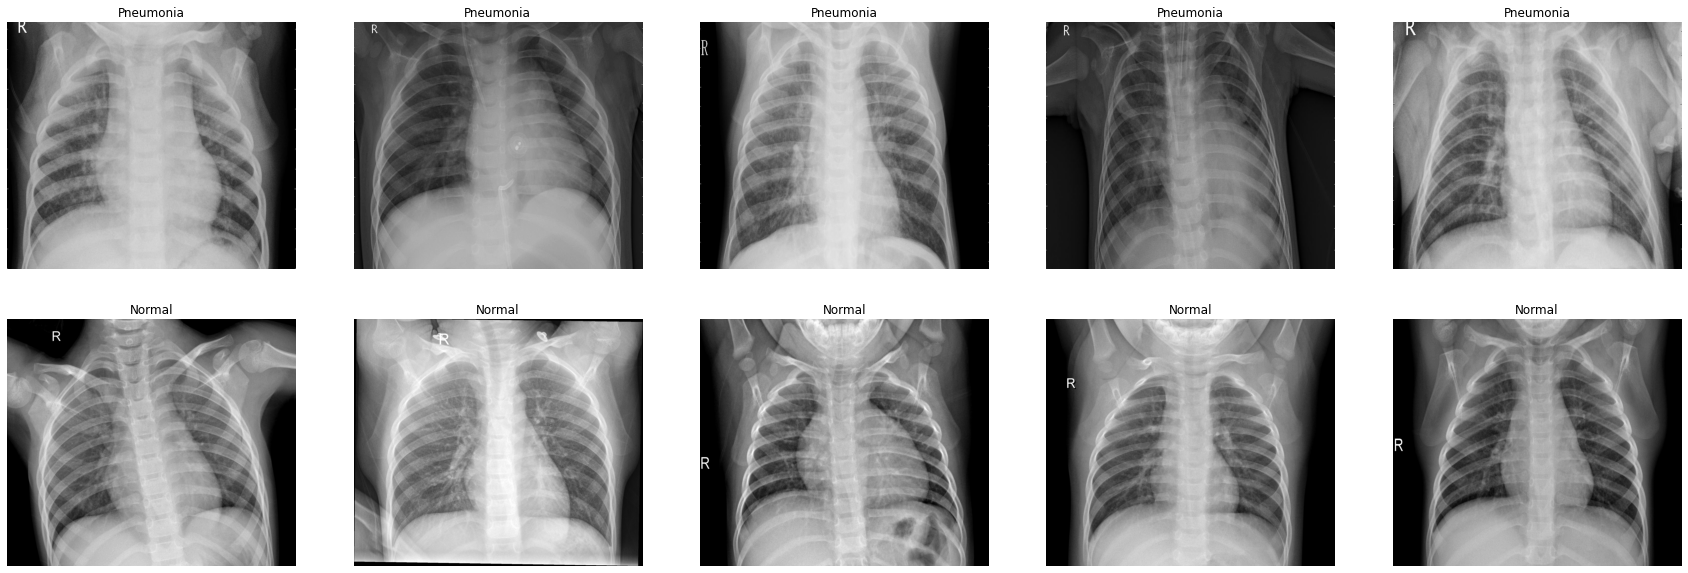

In [4]:
# Obtain random samples
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [5]:

# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    img1 = img[0][0:100] 
    img2 = img[0][100:200] 
    img3 = img[0][200:300]
    if img.shape[2] ==1:
        img = np.hstack([img1, img2, img3])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    img1 = img[0][0:100] 
    img2 = img[0][100:200] 
    img3 = img[0][200:300]
    if img.shape[2] ==1:
        img = np.hstack([img1, img2, img3])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 2)


In [6]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            img1 = img[0][0:100] 
            img2 = img[0][100:200] 
            img3 = img[0][200:300]
            if img.shape[2] ==1:
                img = np.hstack([img1, img2, img3])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [7]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(32, (7,7), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = MaxPooling2D((2,2), name='pool1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = Dropout(0.15, name='dropout1')(x)
    
    x = Conv2D(64, (5,5), activation='relu', padding='same', name='Conv2_1')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Dropout(0.15, name='dropout2')(x)
    
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Dropout(0.15, name='dropout3')(x)
    
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Dropout(0.15, name='dropout4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout5')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout6')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model


In [8]:
model =  build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 32)      4736      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 32)      0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 112, 112, 32)      128       
_________________________________________________________________
dropout1 (Dropout)           (None, 112, 112, 32)      0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 112, 112, 64)      51264     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 64)        0     

In [9]:
import h5py
# Open the VGG16 weight file
f = h5py.File("D:\\Documents\\SanD\\vgg16\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5", 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 32)      4736      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 32)      0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 112, 112, 32)      128       
_________________________________________________________________
dropout1 (Dropout)           (None, 112, 112, 32)      0         
_________________________________________________________________
Conv2_1 (Conv2D)             (None, 112, 112, 64)      51264     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 64)        0     

In [10]:
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [11]:
batch_size = 10
nb_epochs = 15

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 521 and 16


In [12]:
#Fit the model
import time
start = time.time()
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                               validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                               class_weight={0:1.0, 1:0.4})
stop = time.time()
print(f"Training time: {stop - start}s")

C:\Users\mcgonalds\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
521/521 [==============================] - 518s 991ms/step - loss: 0.4785 - accuracy: 0.5171 - val_loss: 9.2407 - val_accuracy: 0.5000
Epoch 2/15
521/521 [==============================] - 502s 963ms/step - loss: 0.3193 - accuracy: 0.6407 - val_loss: 2.6446 - val_accuracy: 0.6250
Epoch 3/15
521/521 [==============================] - 482s 926ms/step - loss: 0.3877 - accuracy: 0.7116 - val_loss: 1.5732 - val_accuracy: 0.8125
Epoch 4/15
521/521 [==============================] - 566s 1s/step - loss: 0.2016 - accuracy: 0.7362 - val_loss: 1.8624 - val_accuracy: 0.8750
Epoch 5/15
521/521 [==============================] - 517s 993ms/step - loss: 0.2051 - accuracy: 0.7137 - val_loss: 4.0153 - val_accuracy: 0.6250
Epoch 6/15
521/521 [==============================] - 514s 986ms/step - loss: 0.1732 - accuracy: 0.7906 - val_loss: 4.1195 - val_accuracy: 0.7500
Epoch 7/15
521/521 [==============================] - 515s 988ms/step - loss: 0.2612 - accuracy: 0.7871 - val_loss: 4.7989 - va

In [13]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [14]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

39/39 [==============================] - 9s 229ms/step - loss: 4.8064 - accuracy: 0.7404
Loss on test set:  4.806366443634033
Accuracy on test set:  0.7403846383094788


In [15]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

orig_test_labels = np.argmax(test_labels, axis=-1)
# Calculate Precision and Recall
cm  = confusion_matrix(orig_test_labels, preds)
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.98
Precision of the model is 0.71


In [16]:
print(tp)
print(fp)
print(tn)
print(fn)

384
156
78
6


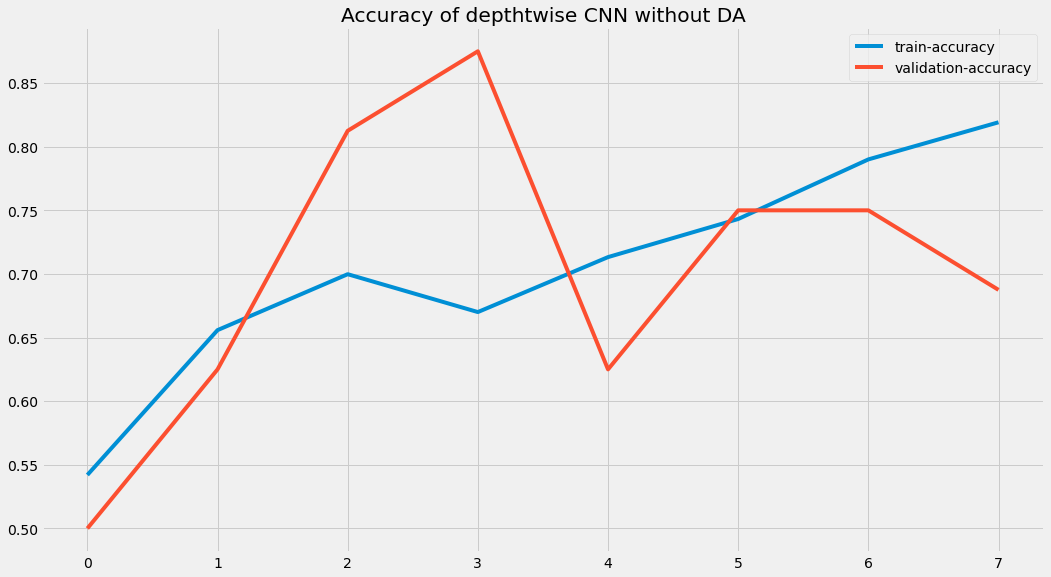

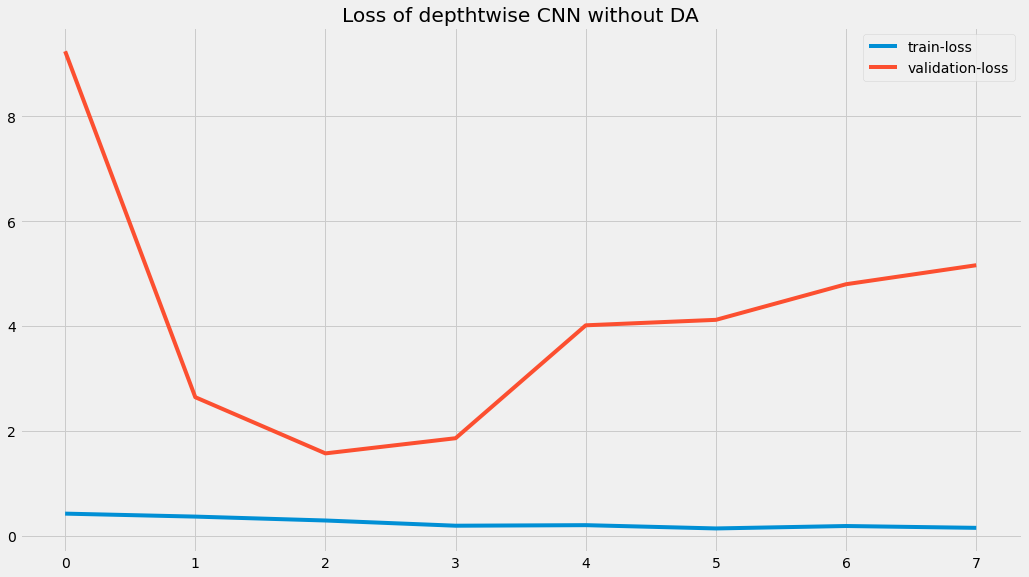

In [19]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(16, 9))
plt.title('Accuracy of depthtwise CNN without DA')
plt.plot(history.epoch, history.history['accuracy'],label ='train-accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label ='validation-accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(16, 9))
plt.title('Loss of depthtwise CNN without DA')
plt.plot(history.epoch, history.history['loss'],label ='train-loss')
plt.plot(history.epoch, history.history['val_loss'],label ='validation-loss')
plt.legend()
plt.show()